***Functions***

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))
def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]
def second_moment(name,para):
    return para[name+'_mean']**2+para[name+'_sd']**2
def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j])
    return C
def algorithms(reg,m,n,g,f,C):
    K=np.exp(-C/C.max()/reg)
    interations=100
    trial=10 #check the optimiality every trial. 
    u=np.ones((n,1))
    u_record=np.ones((n,1))
    for tri in range(trial):
        if sum(abs(u_record-u))<10**(-10):
            for i in range(1,interations):
                v=g/np.dot(K.T,u)
                u=f/np.dot(K,v)
            u_record=u
        else:
            break
    return np.dot(np.diag(u.reshape((1,-1))[0]),np.dot(K,np.diag(v.reshape((1,-1))[0])))

def assess(m,n,g,f,C,output):
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f.reshape(n))))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g.reshape(m))))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(4, 3))
    gs = fig.add_gridspec(2, 2, width_ratios=(bin, 1), height_ratios=(1, bin),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    # ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    # ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    # ax_histx.tick_params(axis="x", labelbottom=False)
    # ax_histy.tick_params(axis="y", labelleft=False)
    # ax_histx.plot(x_range,g)
    # ax_histy.plot(f,x_range) 

def OT(reg,x_range,g,f):
    m=len(g)
    n=len(f)
    C=c_generate(x_range)
    output=algorithms(reg,m,n,g.reshape(m,-1),f.reshape(n,-1),C)
    assess(m,n,g,f,C,output)
    plots(x_range,g,f,output)
    return output

def data_generation(num,para):
    name_list=['af','bf','am','bm']
    df=pd.DataFrame(columns=['X', 'U', 'S'])
    for name in name_list:
        size=int(para[name]*num)
        X=np.floor((np.random.normal(para['X_'+name+'_mean'],para['X_'+name+'_sd'],size=[size])-horizen[0])/width)
        #np.random.normal(para['X_'+name+'_mean'],para['X_'+name+'_sd'],size=[size])
        U=[name[0]]*size
        S=[name[1]]*size
        df=pd.concat([df, pd.DataFrame([X,U,S], index=['X','U','S']).T], ignore_index=True)
    df['W']=1
    df['X']=df['X'].astype('int64')  
    return df

def empirical_distribution(sub,dist):
    bin=dist['bin']
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==i] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','U','S'],as_index=False).sum()
    return df[df['W']!=0]

def projection(df,coupling):
    df_t=pd.DataFrame(columns=['X', 'U', 'S','W'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        rows=np.nonzero(coupling[:,orig[0]])[0]
        sub=pd.DataFrame(columns=['X','W'],index=rows)
        sub['X']=rows 
        sub['W']=coupling[rows,orig[0]]/(sum(coupling[rows,orig[0]])+0.0001)*orig[3]
        sub['U']=orig[1]
        sub['S']=orig[2]
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

def barycenter_projection(df,coupling,para): # for baselines
    U=df['U'].iloc[0]
    df_f=df[df['S']=='f']
    df_m=df[df['S']=='m']
    pi0=para['pi_'+U+'f']
    pi1=para['pi_'+U+'m']

    rows,cols=np.nonzero(coupling)
    num_nzero=len(rows)
    sub=pd.DataFrame(columns=['X','W'],index=range(num_nzero))

    sub['X']=np.floor((pi0*x_range[cols]+pi1*x_range[rows]-horizen[0])/width)
    W_col=[Gaussian_pdf(x_range[c],'X_'+U+'f',para)*width for c in cols]
    W_row=[Gaussian_pdf(x_range[r],'X_'+U+'m',para)*width for r in rows]
    sub['W']=coupling[rows,cols] #*W_col*W_row
    sub['U']=U #df['U'].iloc[0]
    sub=sub[sub['W']!=0]
    sub_f=sub.copy()
    sub_m=sub.copy()
    sub_f['S']='f'
    sub_m['S']='m'
    return pd.concat([sub_f,sub_m], ignore_index=True)

def barycenter_projection1(df,coupling,para):
    U=df['U'].iloc[0]
    df_f=df[df['S']=='f']
    df_m=df[df['S']=='m']
    pi0=para['pi_'+U+'f']
    pi1=para['pi_'+U+'m']
    new_coupling_f=np.zeros((bin,bin))
    new_coupling_m=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            ind_f=int(pi0*i+pi1*j)
            ind_m=int(pi0*j+pi1*i)
            new_coupling_f[ind_f,i]+=coupling[j,i]
            new_coupling_m[ind_m,i]+=coupling[i,j]
    df_Bf=projection(df_f,new_coupling_f)
    df_Bm=projection(df_m,new_coupling_m)
    return pd.concat([df_Bf,df_Bm], ignore_index=True)

def KL_divergence(dist_tmp):
    text=[]
    for u in U_range:
        pf=dist_tmp[u+'f']
        pm=dist_tmp[u+'m']
        q=dist_tmp[u]
        q_supp=np.nonzero(q)[0]
        klf=0
        klm=0
        for i in q_supp: #range(bin):
            if pf[i]!=0:
                klf+=pf[i]*math.log(pf[i]/q[i])
            if pm[i]!=0:
                klm+=pm[i]*math.log(pm[i]/q[i])
        text+=['KL(~||x_{u='+u+'}): '+str(round(klf,4))]
        text+=['KL(~||x_{u='+u+'}): '+str(round(klm,4))]
    return text

***Assumptions***

**S**
* t=1/2-Pr[f]=Pr[m]-1/2=0.1

**S=f**
* U: $B(0.3)$, Pr[a|f]=0.7
* X|U=a: $N(-10,49)$
* X|U=b: $N(-20,49)$

**S=m**
* U: $B(0.7)$, Pr[a|m]=0.3
* X|U=a: $N(20,9)$
* X|U=b: $N(10,9)$

***Definitions***

* **para:** all parameters based on assumptions

* **dist:** all distributions based on assumptions, including target distributions

In [ ]:
keys=['f_a','m_a','f_b','m_b']

In [10]:
U_range=['a','b']
name_list=['af','am','bf','bm']
keys=['f_a','m_a','f_b','m_b']
#keys = ['t','a_f','a_m','b_f','b_m']
values = [0.2,0.8,0.7,0.3]
para = dict(zip(keys, values))
para['X_af_mean']=-8
para['X_af_sd']=3
para['X_bf_mean']=2
para['X_bf_sd']=1
para['X_am_mean']=-2
para['X_am_sd']=3
para['X_bm_mean']=8
para['X_bm_sd']=1
para['f']=0.5
para['m']=0.5
para['a']=para['f_a']+para['m_a']
para['b']=para['f_b']+para['m_b']
para['af']=para['f_a']*para['a']
para['bf']=para['f_b']*para['b']
para['am']=para['m_a']*para['a']
para['bm']=para['m_b']*para['b']
para['pi_af']=para['f_a'] #para['f_a']
para['pi_am']=1-para['pi_af']
para['pi_bf']=para['f_b'] #0.5 #para['f_b']
para['pi_bm']=1-para['pi_bf']

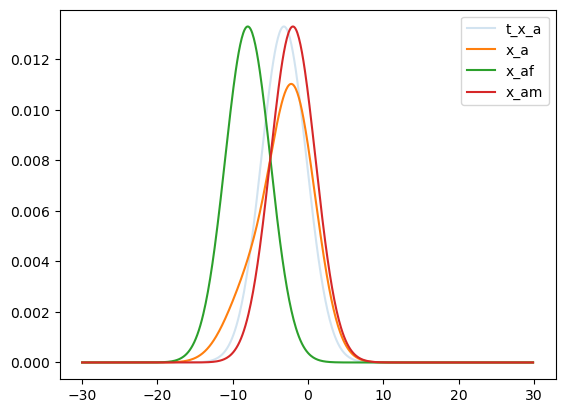

In [11]:
plt.plot(x_range,dist['t_x_a'],label='t_x_a',alpha=0.2)
plt.plot(x_range,dist['x_a'],label='x_a')
plt.plot(x_range,dist['x_af'],label='x_af')
plt.plot(x_range,dist['x_am'],label='x_am')
plt.legend()

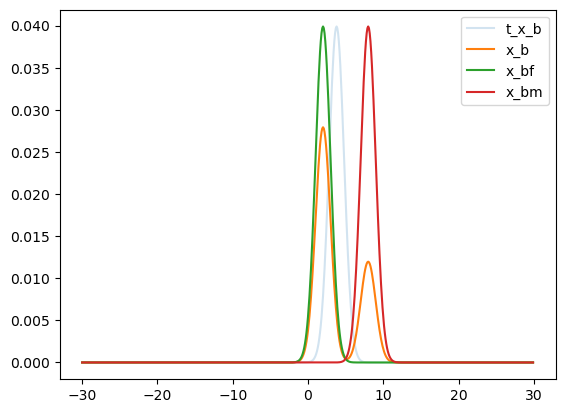

In [12]:
plt.plot(x_range,dist['t_x_b'],label='t_x_b',alpha=0.2)
plt.plot(x_range,dist['x_b'],label='x_b')
plt.plot(x_range,dist['x_bf'],label='x_bf')
plt.plot(x_range,dist['x_bm'],label='x_bm')
plt.legend()

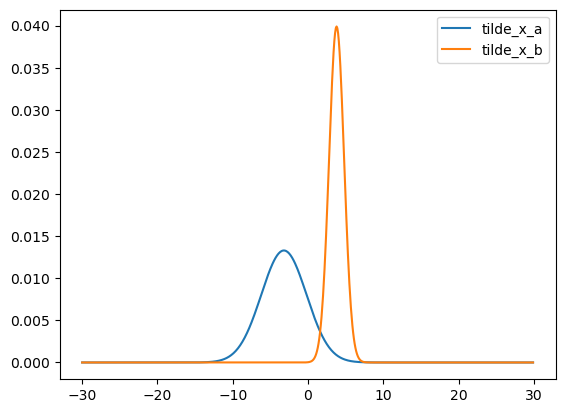

In [15]:
horizen=[-30,30]
width=0.1
bin=int((horizen[1]-horizen[0])/width)
x_range=np.arange(horizen[0],horizen[1],width)
dist = dict(zip(['horizen','width','bin','x_range'],[horizen,width,bin,x_range]))
dist['x_af']=[Gaussian_pdf(x,'X_af',para)*width for x in x_range]
dist['x_am']=[Gaussian_pdf(x,'X_am',para)*width for x in x_range]
dist['x_bf']=[Gaussian_pdf(x,'X_bf',para)*width for x in x_range]
dist['x_bm']=[Gaussian_pdf(x,'X_bm',para)*width for x in x_range]
dist['x_a']=[dist['x_af'][i]*para['f_a']+dist['x_am'][i]*para['m_a'] for i in range(bin)]
dist['x_b']=[dist['x_bf'][i]*para['f_b']+dist['x_bm'][i]*para['m_b'] for i in range(bin)]
dist['t_x_a']=normialise([dist['x_af'][i]**para['f_a']*dist['x_am'][i]**para['m_a'] for i in range(bin)])  
dist['t_x_b']=normialise([dist['x_bf'][i]**para['f_b']*dist['x_bm'][i]**para['m_b'] for i in range(bin)]) 
plt.plot(x_range,dist['t_x_a'],label='tilde_x_a')
plt.plot(x_range,dist['t_x_b'],label='tilde_x_b')
plt.legend()

In [60]:
dist['t_x_a']=dist_project_base['x_am']
dist['t_x_b']=dist_project_base['x_bm']

KeyError: 'x_am'

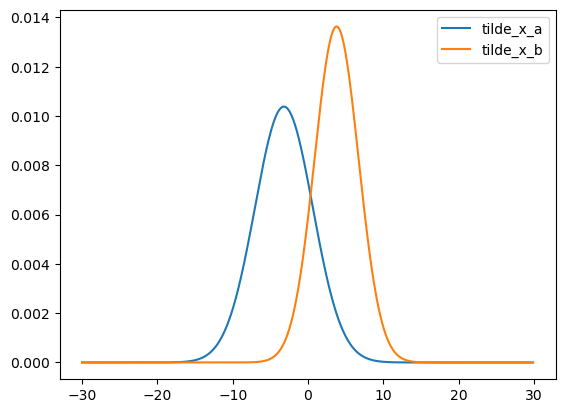

In [14]:
para['X_a_t_mean']=para['X_af_mean']*para['f_a']+para['X_am_mean']*para['m_a']
para['X_a_t_sd']=math.sqrt(second_moment('X_af',para)*para['f_a']+second_moment('X_am',para)*para['m_a']-para['X_a_t_mean']**2)
para['X_b_t_mean']=para['X_bf_mean']*para['f_b']+para['X_bm_mean']*para['m_b']
para['X_b_t_sd']=math.sqrt(second_moment('X_bf',para)*para['f_b']+second_moment('X_bm',para)*para['m_b']-para['X_b_t_mean']**2)
dist['t_x_a']=[Gaussian_pdf(x,'X_a_t',para)*width for x in x_range]
dist['t_x_b']=[Gaussian_pdf(x,'X_b_t',para)*width for x in x_range]
plt.plot(x_range,dist['t_x_a'],label='tilde_x_a')
plt.plot(x_range,dist['t_x_b'],label='tilde_x_b')
plt.legend()

***OT algorithms for our method***

* **output:** couplings for U=a and U=b

top:x_a
right:target_x_a
sum of violation of f: 1.4305785270604588e-16
sum of violation of g: 3.4267258794505505e-14
total cost: 0.9672008690062941
entropy: 6.659340119096211
top:x_b
right:target_x_b
sum of violation of f: 1.0308221624100828e-16
sum of violation of g: 1.4574528403514464e-14
total cost: 1.9415264100285219
entropy: 6.4385447206134945


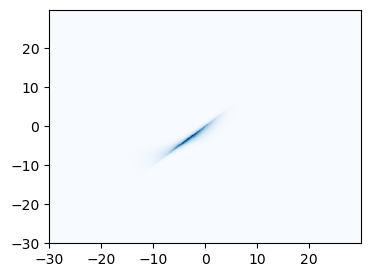

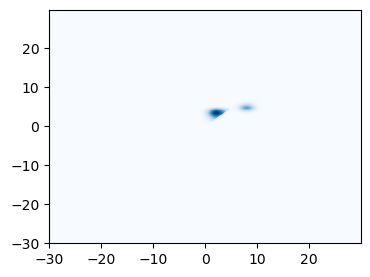

In [16]:
U_range=['a','b']
output=dict(key=U_range)
reg=0.01
for u in U_range:
    print('top:x_'+u)
    print('right:target_x_'+u)
    mu=np.array(dist['x_'+u])
    mu_t=np.array(dist['t_x_'+u])
    output[u]=OT(reg,x_range,mu,mu_t)

***Baselines***: Obtaining fairness using optimal transport theory.arXiv:1806.03195
* Section 5.1.1 Total repair (B) 

top:x_af
right:x_am
sum of violation of f: 1.178642839453818e-16
sum of violation of g: 9.86021889457441e-14
total cost: 6.009137111818827
entropy: 6.821046535204044
top:x_bf
right:x_bm
sum of violation of f: 6.56864866828007e-17
sum of violation of g: 3.2140588122743314e-16
total cost: 6.000001635867422
entropy: 6.357184034676693


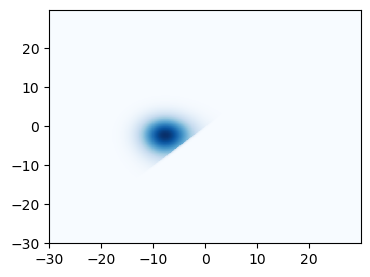

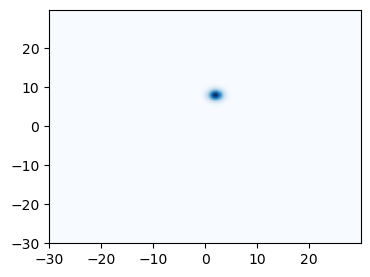

In [17]:
output_base=dict(key=U_range)
reg=0.01 
for u in U_range:
    print('top:x_'+u+'f')
    print('right:x_'+u+'m')
    mu_f=np.array(dist['x_'+u+'f'])
    mu_m=np.array(dist['x_'+u+'m'])
    output_base[u]=OT(reg,x_range,mu_f,mu_m)

coupling[i,j] i from x_am, j from x_af

***Data generation and projection***

* **data:** generated random data
* **data_revised:** data projected by couplings
* **data_revised_base:** data projected by baseline couplings
* **dist_source:** all empiricial distributions of data
* **dist_project:** all empiricial distributions of data_revised
* **dist_project_base:** all empiricial distributions of data_revised_base

In [18]:
num=1000
data=samples_groupby(data_generation(num,para))
data_revised=pd.concat([projection(data[data['U']==u],output[u]) for u in U_range],ignore_index=True)
data_revised_base=pd.concat([barycenter_projection1(data[data['U']==u],output_base[u],para) for u in U_range],ignore_index=True)

In [20]:
dist_source=dict()
dist_project=dict() #dict(keys=['x_'+i for i in name_list])
dist_project_base=dict() #dict(keys=['x_'+i for i in name_list])
for name in name_list:
    dist_source['x_'+name] =empirical_distribution(data[(data['U']==name[0])&(data['S']==name[1])],dist)
    dist_project['x_'+name]=empirical_distribution(data_revised[(data_revised['U']==name[0])&(data_revised['S']==name[1])],dist)
    dist_project_base['x_'+name]=empirical_distribution(data_revised_base[(data_revised_base['U']==name[0])&(data_revised_base['S']==name[1])],dist)

***Evaluations***

In [21]:
dist_original=dict()
dist_project=dict() #dict(keys=['x_'+i for i in name_list])
dist_project_base=dict() #dict(keys=['x_'+i for i in name_list])
for u in U_range:
    dist_original[u]=empirical_distribution(data[(data['U']==u)],dist)
    dist_original[u+'f']=empirical_distribution(data[(data['U']==u)&(data['S']=='f')],dist)
    dist_original[u+'m']=empirical_distribution(data[(data['U']==u)&(data['S']=='m')],dist)

    dist_project[u]=empirical_distribution(data_revised[(data_revised['U']==u)],dist)
    dist_project[u+'f']=empirical_distribution(data_revised[(data_revised['U']==u)&(data_revised['S']=='f')],dist)
    dist_project[u+'m']=empirical_distribution(data_revised[(data_revised['U']==u)&(data_revised['S']=='m')],dist)

    dist_project_base[u]=empirical_distribution(data_revised_base[(data_revised_base['U']==u)],dist)
    dist_project_base[u+'f']=empirical_distribution(data_revised_base[(data_revised_base['U']==u)&(data_revised_base['S']=='f')],dist)
    dist_project_base[u+'m']=empirical_distribution(data_revised_base[(data_revised_base['U']==u)&(data_revised_base['S']=='m')],dist)

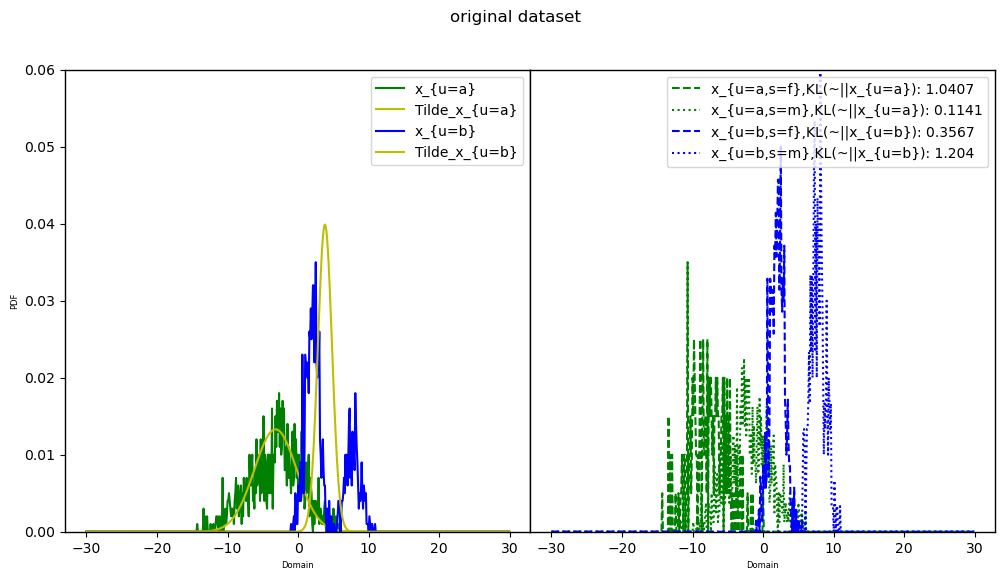

In [22]:
ymax=0.06
dist_tmp=dist_original
text=KL_divergence(dist_tmp)
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
for u in U_range:
    linestyle=str('g' if u=='a' else 'b')
    plt.plot(x_range,dist_tmp[u],linestyle,label='x_{u='+u+'}')
    plt.plot(x_range,dist['t_x_'+u],'y',label='Tilde_x_{u='+u+'}')
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.ylim([0,ymax])
plt.legend()
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
i=0
for key,value in dist_tmp.items():
    if len(key)>1:
        linestyle=str('g' if key[0]=='a' else 'b')+str('--' if key[1]=='f' else ':')
        plt.plot(x_range,value,linestyle,label='x_{u='+key[0]+',s='+key[1]+'},'+text[i])
        i+=1
plt.xlabel('Domain')
plt.ylim([0,ymax])
plt.yticks([])
plt.legend()
#plt.title('original dataset distribution')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
fig.suptitle('original dataset')
plt.savefig('original.pdf',bbox_inches = 'tight')

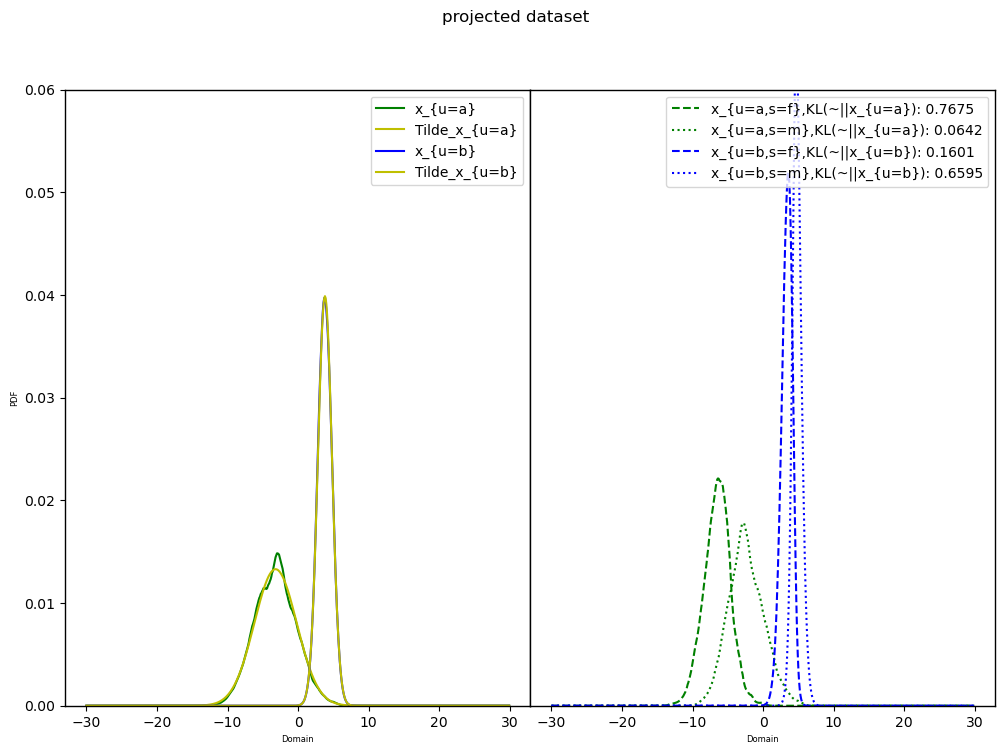

In [23]:
ymax=0.06
dist_tmp=dist_project
text=KL_divergence(dist_tmp)
fig = plt.figure(figsize=(12,8))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
for u in U_range:
    linestyle=str('g' if u=='a' else 'b')
    plt.plot(x_range,dist_tmp[u],linestyle,label='x_{u='+u+'}')
    plt.plot(x_range,dist['t_x_'+u],'y',label='Tilde_x_{u='+u+'}')
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.ylim([0,ymax])
plt.legend()
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
i=0
for key,value in dist_tmp.items():
    if len(key)>1:
        linestyle=str('g' if key[0]=='a' else 'b')+str('--' if key[1]=='f' else ':')
        plt.plot(x_range,value,linestyle,label='x_{u='+key[0]+',s='+key[1]+'},'+text[i])
        i+=1
plt.xlabel('Domain')
plt.ylim([0,ymax])
plt.yticks([])
plt.legend()
#plt.title('original dataset distribution')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
fig.suptitle('projected dataset')
plt.savefig('projected.pdf',bbox_inches = 'tight')

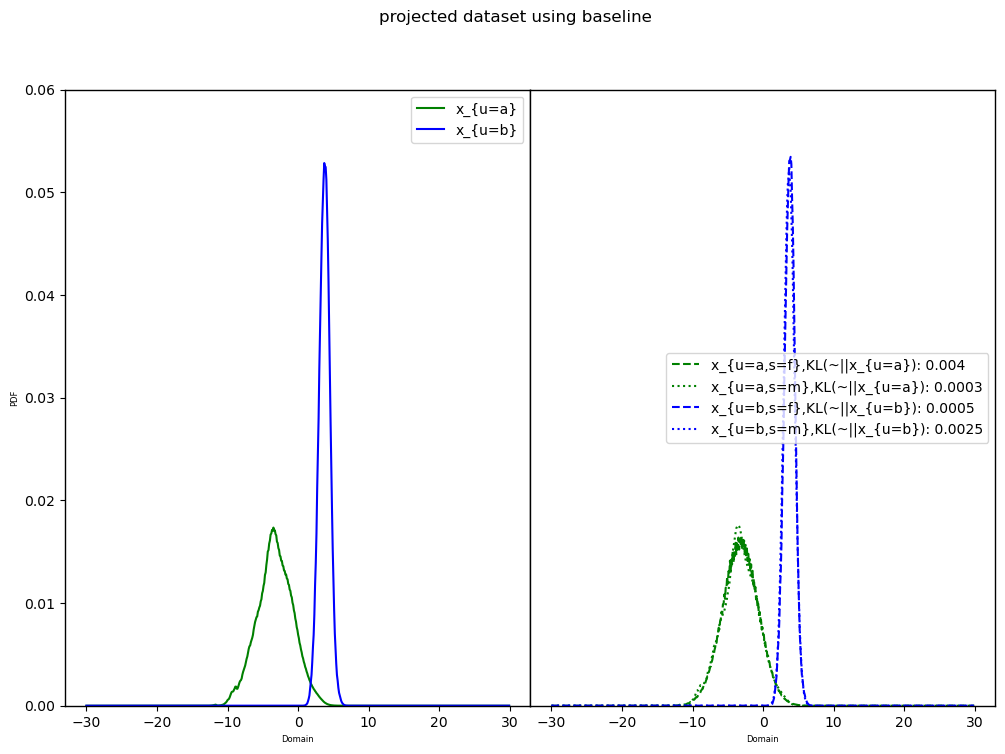

In [24]:
ymax=0.06
dist_tmp=dist_project_base
text=KL_divergence(dist_tmp)
fig = plt.figure(figsize=(12,8))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
for u in U_range:
    linestyle=str('g' if u=='a' else 'b')
    plt.plot(x_range,dist_tmp[u],linestyle,label='x_{u='+u+'}')
    #plt.plot(x_range,dist['t_x_'+u],'y',label='Tilde_x_{u='+u+'}')
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.ylim([0,ymax])
plt.legend()
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
i=0
for key,value in dist_tmp.items():
    if len(key)>1:
        linestyle=str('g' if key[0]=='a' else 'b')+str('--' if key[1]=='f' else ':')
        plt.plot(x_range,value,linestyle,label='x_{u='+key[0]+',s='+key[1]+'},'+text[i])
        i+=1
plt.xlabel('Domain')
plt.ylim([0,ymax])
plt.yticks([])
plt.legend()
#plt.title('original dataset distribution')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
fig.suptitle('projected dataset using baseline')
plt.savefig('projected_base.pdf',bbox_inches = 'tight')

Check if the coupling satisfies \sum_{j} coupling[u][j,i]= dist[x_u] and \sum_{i} coupling[u][j,i]= dist[Tilde_x_u]

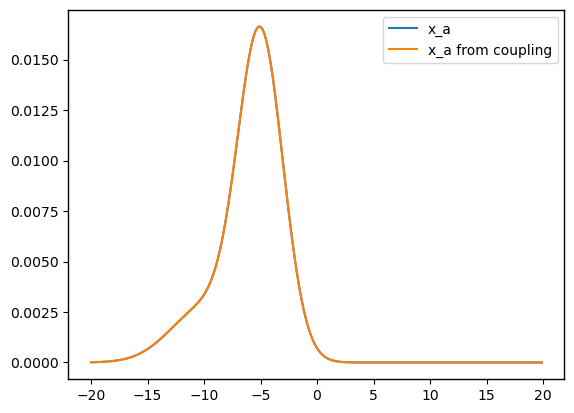

In [100]:
plt.plot(x_range,dist['x_a'],label='x_a')
plt.plot(x_range,[sum(output['a'][j,i] for j in range(bin)) for i in range(bin)],label='x_a from coupling')
plt.legend()

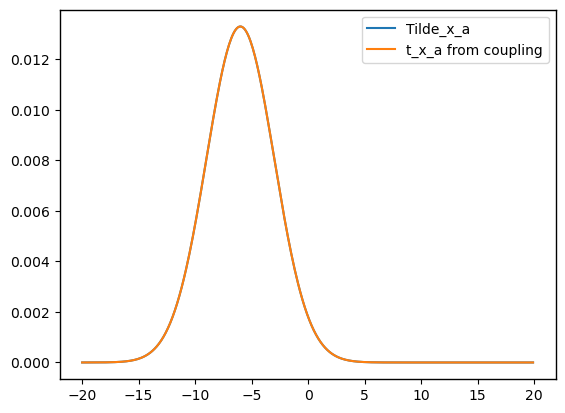

In [101]:
plt.plot(x_range,dist['t_x_a'],label='Tilde_x_a')
plt.plot(x_range,[sum(output['a'][j,i] for i in range(bin)) for j in range(bin)],label='t_x_a from coupling')
plt.legend()

Check if the projection function T_u transport dist[x_u] to dist[Tilde_x_u]

In [102]:
X=[*range(bin)]
U=['a']*bin
S=['f']*bin
W=[dist['x_a'][i]*1000 for i in range(bin)]

In [103]:
data_fake=pd.DataFrame([X,U,S,W], index=['X','U','S','W']).T
data_fake=data_fake[data_fake['W']!=0]
data_fake['X']=data_fake['X'].astype('int64') 

In [104]:
data_fake_project=projection(data_fake,output['a'])

In [105]:
dist_fake_project=empirical_distribution(data_fake_project,dist)

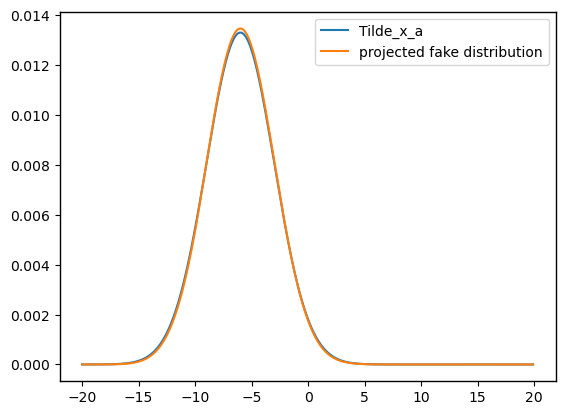

In [106]:
plt.plot(x_range,dist['t_x_a'],label='Tilde_x_a')
plt.plot(x_range,dist_fake_project,label='projected fake distribution')
plt.legend()